In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

engine = create_engine("postgresql://localhost/postgres")

Matplotlib is building the font cache; this may take a moment.


In [2]:
tweets         = pd.read_sql_table('tweets',         con=engine)
author_metrics = pd.read_sql_table('author_metrics', con=engine)
tweet_metrics  = pd.read_sql_table('tweet_metrics',  con=engine)
entity_feats   = pd.read_sql_table('entity_features',con=engine)
text_feats     = pd.read_sql_table('text_features',  con=engine)
embeddings     = pd.read_sql_table('embeddings',     con=engine)

In [3]:
for df, name in [(tweets,'tweets'),
                 (author_metrics,'author_metrics'),
                 (tweet_metrics,'tweet_metrics'),
                 (entity_feats,'entity_features'),
                 (text_feats,'text_features')]:
    print(name, df.shape)

tweets (134198, 5)
author_metrics (134198, 11)
tweet_metrics (134198, 10)
entity_features (134198, 1)
text_features (134198, 22)


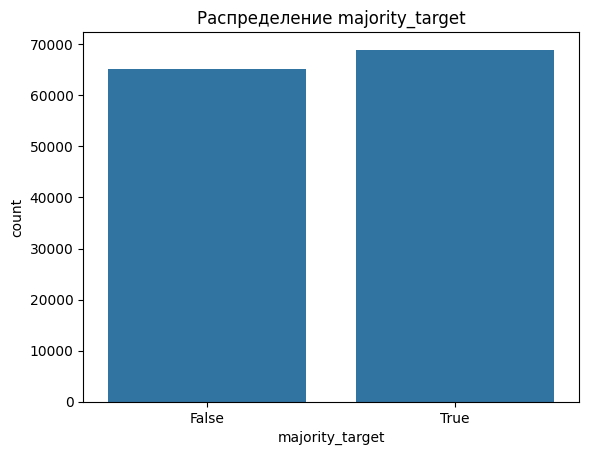

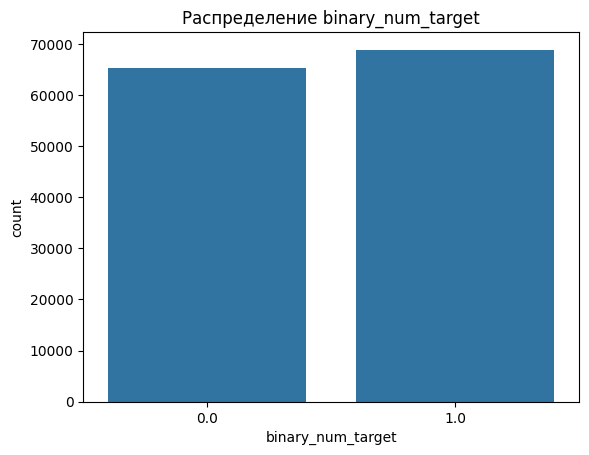

In [4]:
fig, ax = plt.subplots()
sns.countplot(x='majority_target', data=tweets, ax=ax)
ax.set_title('Распределение majority_target')
plt.show()

fig, ax = plt.subplots()
sns.countplot(x='binary_num_target', data=tweets, ax=ax)
ax.set_title('Распределение binary_num_target')
plt.show()

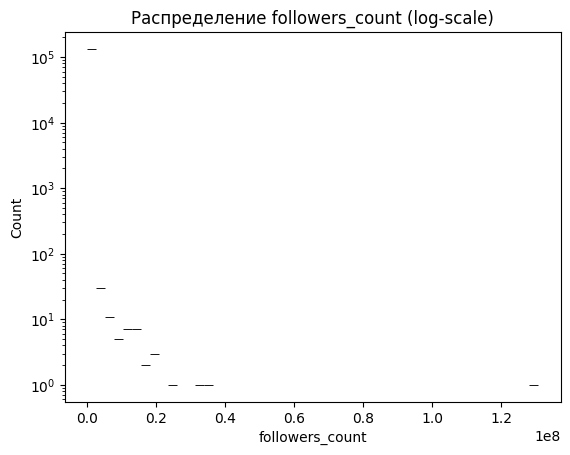

In [5]:
fig, ax = plt.subplots()
sns.histplot(author_metrics['followers_count']+1, log_scale=(False, True), bins=50, ax=ax)
ax.set_title('Распределение followers_count (log-scale)')
plt.show()

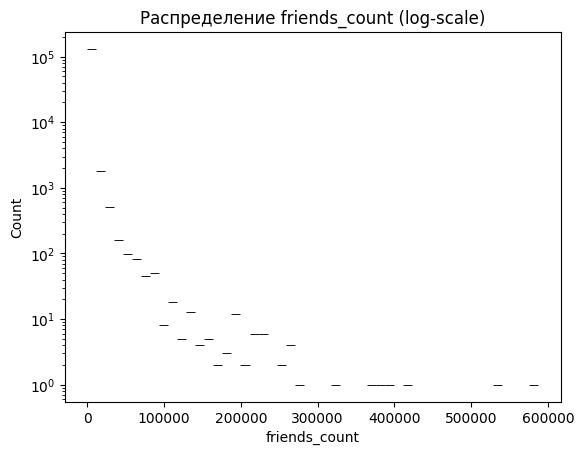

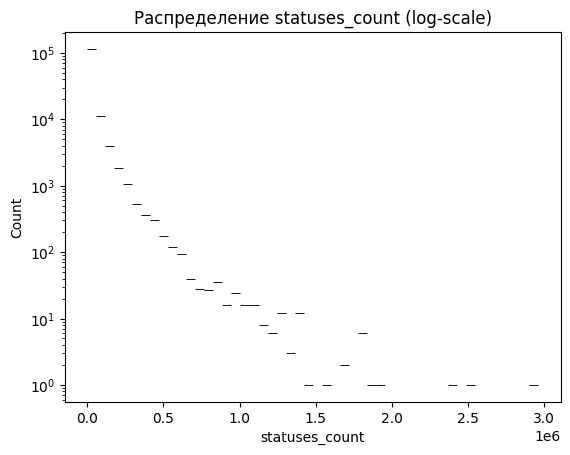

In [6]:
for col in ['friends_count','statuses_count']:
    fig, ax = plt.subplots()
    sns.histplot(author_metrics[col]+1, log_scale=(False, True), bins=50, ax=ax)
    ax.set_title(f'Распределение {col} (log-scale)')
    plt.show()

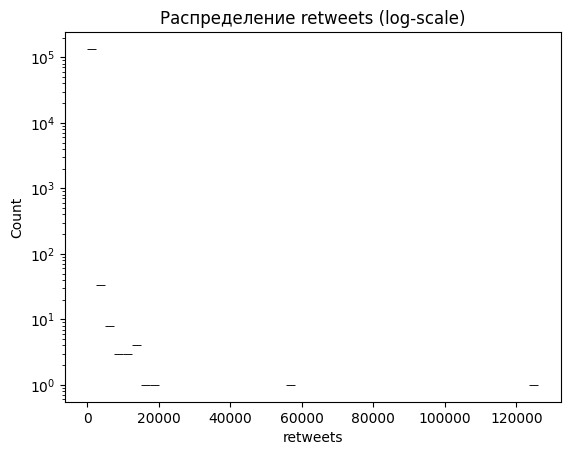

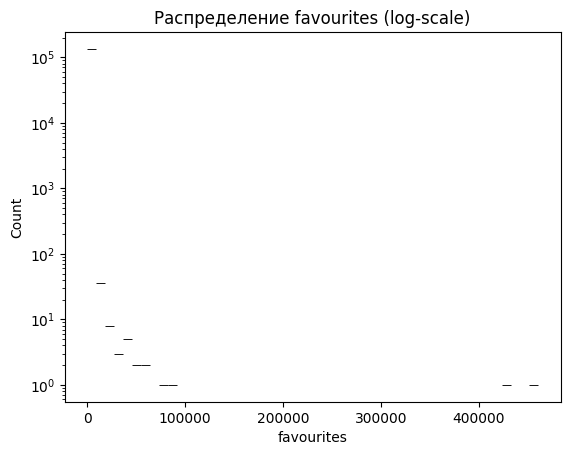

In [7]:
for col in ['retweets','favourites']:
    fig, ax = plt.subplots()
    sns.histplot(tweet_metrics[col]+1, log_scale=(False, True), bins=50, ax=ax)
    ax.set_title(f'Распределение {col} (log-scale)')
    plt.show()

In [8]:
corr_df = pd.concat([
    author_metrics[['followers_count','friends_count']],
    tweet_metrics[['retweets','favourites']],
    text_feats[['word_count','avg_word_length']]
], axis=1)

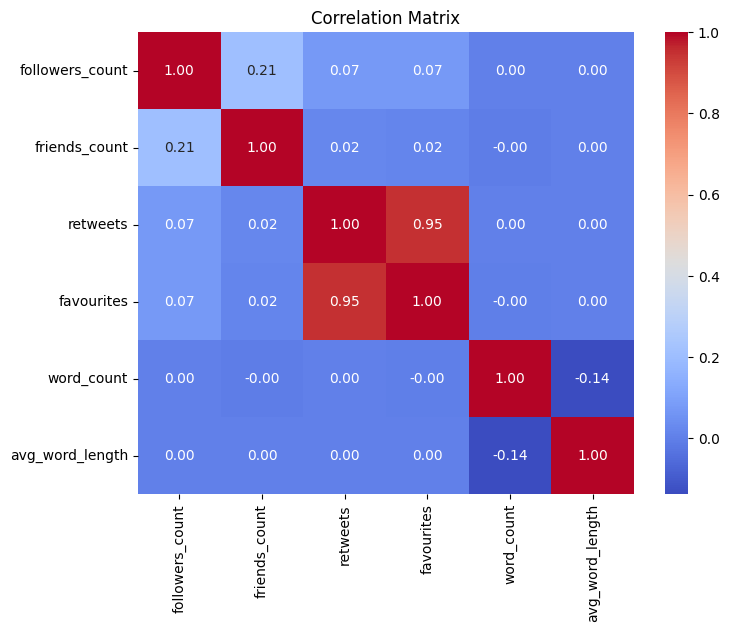

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(corr_df.corr(), annot=True, fmt=".2f", cmap='coolwarm', ax=ax)
ax.set_title('Correlation Matrix')
plt.show()

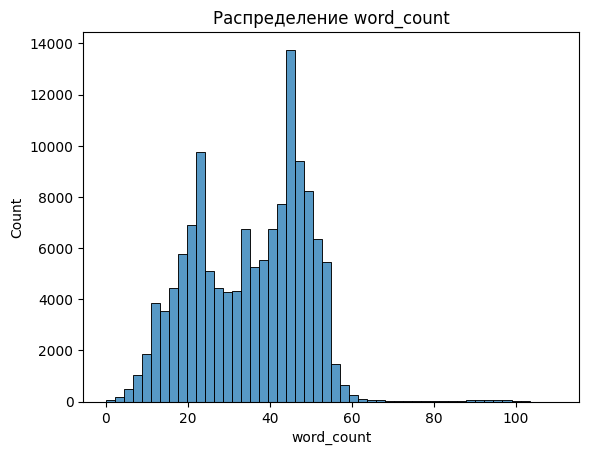

In [10]:
fig, ax = plt.subplots()
sns.histplot(text_feats['word_count'], bins=50, ax=ax)
ax.set_title('Распределение word_count')
plt.show()

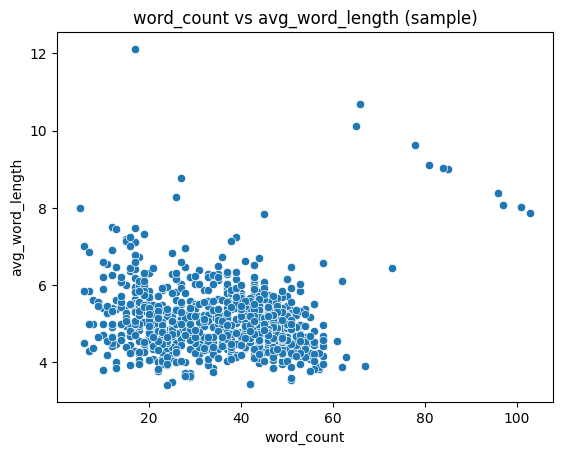

In [11]:
fig, ax = plt.subplots()
sns.scatterplot(x='word_count', y='avg_word_length', data=text_feats.sample(1000), ax=ax)
ax.set_title('word_count vs avg_word_length (sample)')
plt.show()

In [12]:
entity_feats.mean().sort_values(ascending=False).head(10)

tweet_idx    67098.5
dtype: float64

In [ ]:
# Выводы

1. **Баланс целевых меток**  
   Значения `majority_target` и `binary_num_target` распределены почти поровну (~65 000 vs 70 000 записей), что позволяет строить модели без сильного дисбаланса классов.

2. **Широкий разброс метрик авторов**  
   Распределения `followers_count`, `friends_count` и `statuses_count` имеют «тяжёлые хвосты» — большинство аккаунтов с небольшим числом подписчиков/друзей, но есть редкие супер-инфлюенсеры с миллионами подписчиков.

3. **Активность твитов также неравномерна**  
   Большинство твитов получают мало ретвитов и лайков, однако есть единичные «вирусные» записи с десятками тысяч реакций.

4. **Связь ретвитов и лайков**  
   Между числом ретвитов и лайков очень высокая корреляция (r≈0.95), тогда как корреляция между авторскими метриками и вовлечённостью слабая (r≈0.07), что говорит об основном влиянии контента, а не размера аудитории.

5. **Текстовые характеристики**  
   Среднее число слов во фрагменте — ~40, средняя длина слова ~5–6 символов. Разброс длины текста невелик, что упрощает дальнейшую обработку NLP-моделями.